In [1]:
import unicodecsv 
#读入数据
def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

enrollments = read_csv('data/enrollments.csv')
daily_engagement = read_csv('data/daily_engagement.csv')
project_submissions = read_csv('data/project_submissions.csv')


In [2]:
from datetime import datetime as dt
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y/%m/%d')
def parse_date2(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
#修正数据类型
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

for enrollment in enrollments:
    enrollment['cancel_date']=parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel']=parse_maybe_int(enrollment['days_to_cancel'])  
    enrollment['is_canceled']= enrollment['is_canceled'] == 'TRUE'
    enrollment['is_udacity']= enrollment['is_udacity'] == 'TRUE'
    enrollment['join_date']= parse_date(enrollment['join_date'])
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date2(engagement_record['utc_date'])


In [3]:
enrollment_num_rows = len(enrollments)             # Replace this with your code
enrollment_unique_students = set()
for i in enrollments:
    enrollment_unique_students.add(i['account_key'])

enrollment_num_unique_students = len(enrollment_unique_students)  # Replace this with your code
engagement_num_rows = len(daily_engagement)                # Replace this with your code

engagement_unique_students = set()
for i in daily_engagement:
    engagement_unique_students.add(i['acct'])

engagement_num_unique_students = len(engagement_unique_students)  # Replace this with your code
submission_num_rows = len(project_submissions)                # Replace this with your code

submission_unique_rows = set()
for i in project_submissions:
    submission_unique_rows.add(i['account_key'])
submission_num_unique_students = len(submission_unique_rows)  # Replace this with your code

In [4]:
print enrollment_num_unique_students
print engagement_num_unique_students

1302
1237


In [5]:
#修正字段名称
for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del[engagement_record['acct']]

In [6]:
#发现问题数据。问题是：有这样一类同学，加入日期不等于注销日期，并且从来不在课程列表中出现，原因是，这些是测试账户！
num_problem_students = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in engagement_unique_students and (enrollment['cancel_date'] != enrollment['join_date']):        
        num_problem_students += 1

In [7]:
#找到测试账户
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [8]:
#删除Udacity测试用户
def remove_udacity_accounts(data):
    non_udacity_data=[]
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [9]:
non_udacity_enrollment = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)
print len(non_udacity_enrollment)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


In [10]:
#统计注销日期大于七天或者没有被注销的人数
paid_students = {}
for enrollment in non_udacity_enrollment:
    if (not enrollment['is_canceled'] or
            enrollment['days_to_cancel'] > 7):
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        if (account_key not in paid_students or
                enrollment_date > paid_students[account_key]):
            paid_students[account_key] = enrollment_date
len(paid_students)

995

In [11]:
#挑选出 在注册后一周之内参加课程的学生
def within_one_week(join_date, engagement_date):
    time_date = engagement_date - join_date
    return time_date.days < 7 and time_date.days >=0

In [12]:
#####
#   #
# 7 #
#   #
#####
def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

paid_enrollments = remove_free_trial_cancels(non_udacity_enrollment)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print len(paid_enrollments)
print len(paid_engagement)
print len(paid_submissions)

1293
134549
3618


In [13]:
for engagement_record in paid_engagement:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [14]:
paid_engagement_in_first_week = []
for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']

    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)

len(paid_engagement_in_first_week)

6919

In [15]:
from collections import defaultdict

def group_data(data, key_name):

    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')

In [16]:
def sum_grouped_items(grouped_data, field_name):
    sum_by_grouped_data = {}
    for keys, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        sum_by_grouped_data[keys] = total
    return sum_by_grouped_data

total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')
#total_lessons_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')

Populating the interactive namespace from numpy and matplotlib
Mean 306.708326753
Std 412.996933409
Min 0.0
Max 3564.7332645


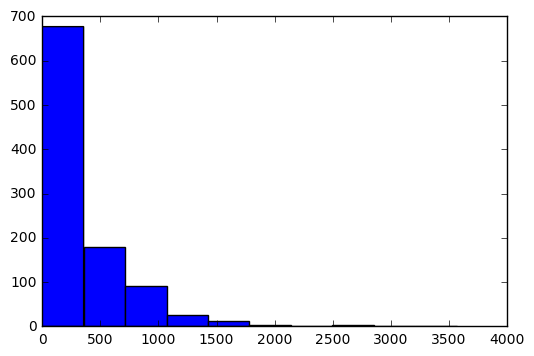

In [38]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

def describe_data(data):
    print 'Mean' , np.mean(data)
    print 'Std' , np.std(data)
    print 'Min' , np.min(data)
    print 'Max' , np.max(data)
    plt.hist(data)
    
total_minutes = total_minutes_by_account.values()
describe_data(total_minutes)

In [40]:
#调试数据分析代码
student_with_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student

max_minutes

3564.7332644989997

In [41]:
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print engagement_record

{u'lessons_completed': 4, u'num_courses_visited': 4, 'has_visited': 1, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, 'has_visited': 1, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, 'has_visited': 1, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, 'has_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, 'has_visited': 1, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, 'account_key': u'163

Mean 1.63618090452
Std 3.00256129983
Min 0
Max 36


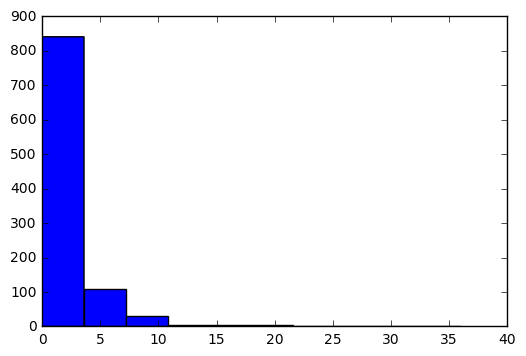

In [42]:
lessons_completed_by_account = sum_grouped_items(engagement_by_account,
                                                'lessons_completed')
describe_data(lessons_completed_by_account.values())

Mean 2.86733668342
Std 2.25519800292
Min 0
Max 7


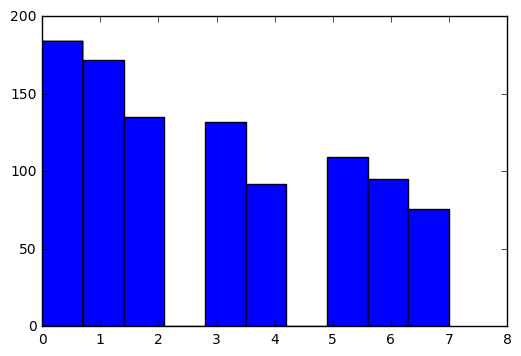

In [43]:
days_visited_by_account = sum_grouped_items(engagement_by_account,'has_visited')
describe_data(days_visited_by_account.values())

In [44]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in paid_submissions:
    project = submission['lesson_key']
    rating = submission['assigned_rating']    

    if ((project in subway_project_lesson_keys) and
            (rating == 'PASSED' or rating == 'DISTINCTION')):
        pass_subway_project.add(submission['account_key'])

len(pass_subway_project)

passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)

print len(passing_engagement)
print len(non_passing_engagement)

4527
2392


non-passing students:
Mean 143.326474267
Std 269.538619011
Min 0.0
Max 1768.52274933
passing students:
Mean 394.586046484
Std 448.499519327
Min 0.0
Max 3564.7332645
non-passing students:
Mean 0.862068965517
Std 2.54915994183
Min 0
Max 27
passing students:
Mean 2.05255023184
Std 3.14222705558
Min 0
Max 36
non-passing students:
Mean 1.90517241379
Std 1.90573144136
Min 0
Max 7
passing students:
Mean 3.38485316847
Std 2.25882147092
Min 0
Max 7


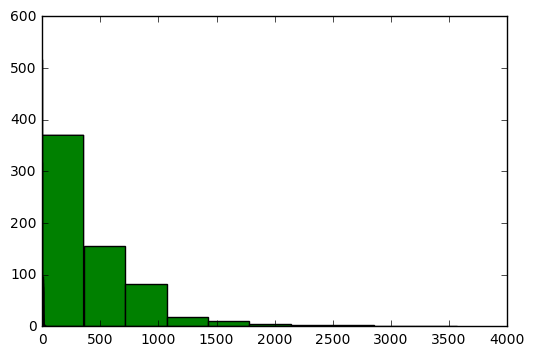

In [45]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).
passing_engagement_by_account = group_data(passing_engagement,
                                           'account_key')
non_passing_engagement_by_account = group_data(non_passing_engagement,
                                               'account_key')

print 'non-passing students:'
non_passing_minutes = sum_grouped_items(
    non_passing_engagement_by_account,
    'total_minutes_visited'
)
describe_data(non_passing_minutes.values())

print 'passing students:'
passing_minutes = sum_grouped_items(
    passing_engagement_by_account,
    'total_minutes_visited'
)
describe_data(passing_minutes.values())

print 'non-passing students:'
non_passing_lessons = sum_grouped_items(
    non_passing_engagement_by_account,
    'lessons_completed'
)
describe_data(non_passing_lessons.values())

print 'passing students:'
passing_lessons = sum_grouped_items(
    passing_engagement_by_account,
    'lessons_completed'
)
describe_data(passing_lessons.values())

non-passing students:
Mean 1.90517241379
Std 1.90573144136
Min 0
Max 7
passing students:
Mean 3.38485316847
Std 2.25882147092
Min 0
Max 7


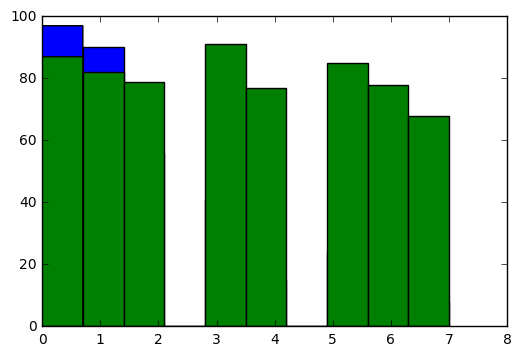

In [46]:
print 'non-passing students:'
non_passing_visits = sum_grouped_items(
    non_passing_engagement_by_account, 
    'has_visited'
)
describe_data(non_passing_visits.values())

print 'passing students:'
passing_visits = sum_grouped_items(
    passing_engagement_by_account,
    'has_visited'
)
describe_data(passing_visits.values())

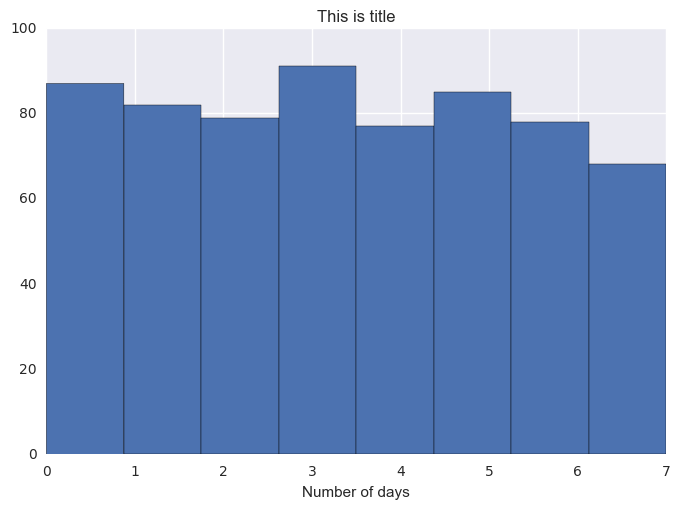

In [58]:
import seaborn as sns
plt.hist(passing_visits.values(),bins=8)
plt.xlabel('Number of days')
plt.title('This is title')

In [49]:
import seaborn as sns
plt.hist(non_passing_visits.values())

ImportError: No module named seaborn

In [ ]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.